In [2]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [3]:
# 예제 8.01 알렉스넷 모델 구조 출력

from torchvision import models
from torchinfo import summary


model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1")
summary(model, (1, 3, 224, 224), device="cpu")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/bumchanpark/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:32<00:00, 7.62MB/s] 


Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [8]:
# 예제 8.02 클래스 정보 파일 불러오기

with open("../data/imagenet_classes.txt", "r") as file:
    classes = file.read().splitlines()
    
print(f"클래스 개수 : {len(classes)}")
print(f"첫 번째 클래스 레이블 : {classes[0]}")

클래스 개수 : 1000
첫 번째 클래스 레이블 : tench


In [7]:
# 예제 8.03 이미지 데이터 전처리

import torch
from PIL import Image
from torchvision import models, transforms


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1").eval().to(device)

tensors = []
files = ["../images/airplane.jpg", "../images/bus.jpg"]
for file in files:
    image = Image.open(file)
    tensors.append(transform(image))

tensors = torch.stack(tensors)
print(f"입력 텐서의 크기 : {tensors.shape}")

입력 텐서의 크기 : torch.Size([2, 3, 224, 224])


In [9]:
# 예제 8.04 알렉스넷 모델 추론

import numpy as np
from torch.nn import functional as F


with torch.no_grad():
    outputs = model(tensors.to(device))
    probs = F.softmax(outputs, dim=-1)
    top_probs, top_idxs = probs.topk(5)

top_probs = top_probs.detach().cpu().numpy()
top_idxs = top_idxs.detach().cpu().numpy()
top_classes = np.array(classes)[top_idxs]

for idx, (cls, prob) in enumerate(zip(top_classes, top_probs)):
    print(f"{files[idx]} 추론 결과")
    for c, p in zip(cls, prob):
        print(f" - {c:<30} : {p * 100:>5.2f}%")

../images/airplane.jpg 추론 결과
 - airliner                       : 73.45%
 - warplane                       : 14.44%
 - wing                           :  9.56%
 - space shuttle                  :  1.94%
 - missile                        :  0.25%
../images/bus.jpg 추론 결과
 - streetcar                      : 60.25%
 - trolleybus                     : 37.99%
 - minibus                        :  1.54%
 - passenger car                  :  0.17%
 - recreational vehicle           :  0.03%


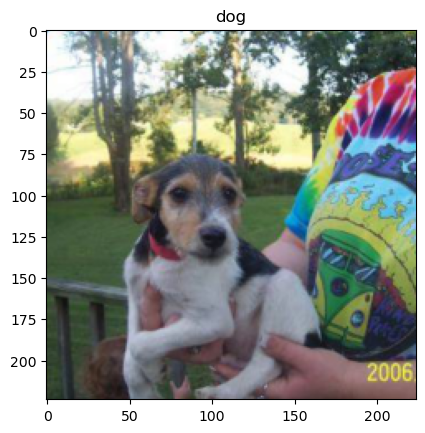

In [20]:
# 예제 8.05~8.06 하이퍼파라미터 선언 및 이미지 변환, 데이터 시각화

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt

hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )
}

train_dataset = ImageFolder("../data/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("../data/pet/test", transform=hyperparams["transform"])

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

mean=[0.48235, 0.45882, 0.40784]
std=[0.229, 0.224, 0.225]

images, labels = next(iter(train_dataloader))
for image, label in zip(images, labels):
    image = image.numpy().transpose((1, 2, 0))
    image = ((std * image + mean) * 255).astype(np.uint8)

    plt.imshow(image)
    plt.title(train_dataset.classes[int(label)])
    plt.show()
    break

In [ ]:
# 예제 8.07~8.09 VGG-16 모델 실습

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    ),
}
train_dataset = ImageFolder("../data/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("../data/pet/test", transform=hyperparams["transform"])

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

for epoch in range(hyperparams["epochs"]):
    cost = 0.0

    for images, classes in train_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, classes in test_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)

        accuracy += int(torch.eq(classes, outputs_classes).sum())

    print(f"acc@1 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")

torch.save(model.state_dict(), "../models/VGG16.pt")
print("Saved the model weights")

In [ ]:
# 예제 8.10~8.13 레즈넷 모델 구현

from torch import nn


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
import torch


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ) 
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [ ]:
from torchvision import models
from torchinfo import summary


resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 1000)
resnet101 = ResNet(BottleneckBlock, [3, 4, 23, 3], 1000)
resnet152 = ResNet(BottleneckBlock, [3, 8, 36, 3], 1000)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

print(resnet34_info.total_params)
print(torch_model_info.total_params)

In [ ]:
# 예제 8.14~8.17 클래스 활성화 맵 실습

from torch import nn
from torchvision import models


model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval()
features = nn.Sequential(*list(model.children())[:-2])

In [ ]:
from PIL import Image
from torchvision import transforms


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

image = Image.open("../datasets/images/airplane.jpg")
target = transform(image).unsqueeze(0)

output = model(target)
class_idx = int(output.argmax())

weights = model.fc.weight[class_idx].reshape(-1, 1, 1)
features_output = features(target).squeeze()

print(weights.shape)
print(features_output.shape)

In [ ]:
import torch
from torch.nn import functional as F


cam = features_output * weights
cam = torch.sum(cam, dim=0)
cam = F.interpolate(
    input=cam.unsqueeze(0).unsqueeze(0),
    size=(image.size[1], image.size[0]),
    mode="bilinear",
).squeeze().detach().numpy()

In [ ]:
import matplotlib.pyplot as plt


plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()

In [ ]:
# 예제 8.18~8.20 Grad-CAM 실습

import torch


class GradCAM:
    def __init__(self, model, main, sub):
        self.model = model.eval()
        self.register_hook(main, sub)

    def register_hook(self, main, sub):
        for name, module in self.model.named_children():
            if name == main:
                for sub_name, sub_module in module[-1].named_children():
                    if sub_name == sub:
                        sub_module.register_forward_hook(self.forward_hook)
                        sub_module.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.feature_map = output  

    def backward_hook(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]
        
    def __call__(self, x):
        output = self.model(x)

        index = output.argmax(axis=1)
        one_hot = torch.zeros_like(output)                
        for i in range(output.size(0)):
            one_hot[i][index[i]] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)

        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        grad_cam = torch.sum(a_k * self.feature_map, dim=1)
        grad_cam = torch.relu(grad_cam)
        return grad_cam

In [ ]:
from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

files = [
    "../datasets/images/airplane.jpg", "../datasets/images/bus.jpg",
    "../datasets/images/dog.jpg", "../datasets/images/african_hunting_dog.jpg"
]
images, tensors = [], []
for file in files:
    image = Image.open(file)
    images.append(image)
    tensors.append(transform(image))
tensors = torch.stack(tensors)

model = GradCAM(
    model=models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),
    main="layer4",
    sub="conv2"
)
grad_cams = model(tensors)

for idx, image in enumerate(images):
    grad_cam = F.interpolate(
        input=grad_cams[idx].unsqueeze(0).unsqueeze(0),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    ).squeeze().detach().numpy()

    plt.imshow(image)
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()